# Библиотеки

In [ ]:
%%capture
!pip install corus pandas nltk pymorphy3 scikit-learn nltk gensim navec

In [ ]:
from corus import load_lenta
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymorphy3
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import functools
from sklearn.model_selection import train_test_split
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from navec import Navec
import urllib.request
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from sklearn.metrics import classification_report
from functools import lru_cache
from joblib import Parallel, delayed

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Получение репрезентативной части датасета

**Размер:** 100000 текстов в датафрейме

In [ ]:
!wget https://github.com/yutkin/Lenta.Ru-News-Dataset/releases/download/v1.0/lenta-ru-news.csv.gz

In [ ]:
path = 'lenta-ru-news.csv.gz'
records = load_lenta(path)

In [ ]:
data = []
for record in records:
    data.append({
        'title': record.title,
        'text': record.text,
        'topic': record.topic
    })

df = pd.DataFrame(data)

In [ ]:
df.head()

,title,text,topic
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир


In [ ]:
df.shape

(739351, 3)

<ipython-input-9-1be13f182f84>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")


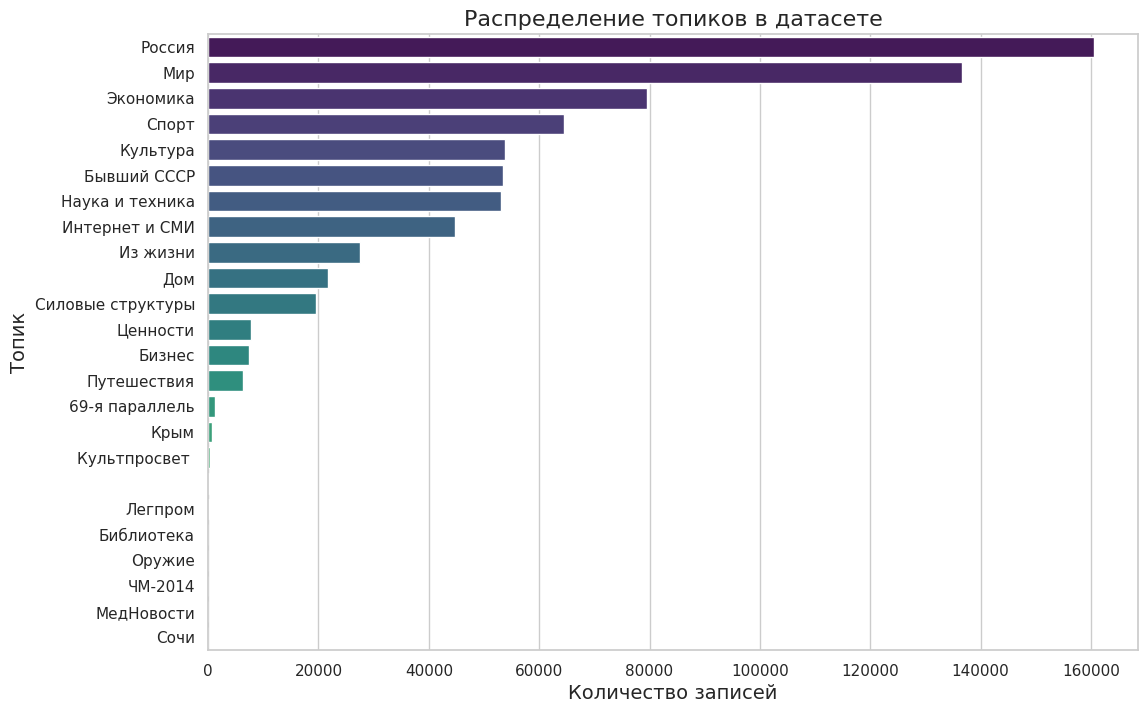

In [ ]:
sns.set(style="whitegrid")
topic_counts = df['topic'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")
plt.title('Распределение топиков в датасете', fontsize=16)
plt.xlabel('Количество записей', fontsize=14)
plt.ylabel('Топик', fontsize=14)
plt.show()

In [ ]:
topic_counts

,count
topic,
Россия,160519
Мир,136680
Экономика,79538
Спорт,64421
Культура,53803
Бывший СССР,53402
Наука и техника,53136
Интернет и СМИ,44675
Из жизни,27611


> Функция `find_optimal_base_class` определяет базовый класс, чтобы вошло максимальное кол-во топиков в датасет при ограничении в 100 тыс. текстов.



In [ ]:
def find_optimal_base_class(topic_counts, max_samples=100000):
    best = {}
    sorted_topics = topic_counts.sort_values(ascending=False)

    for topic, count in sorted_topics.items():
        eligible = sorted_topics[sorted_topics >= count]
        base_size = len(eligible) * count

        if base_size > max_samples:
            continue

        remaining = max_samples - base_size
        extra_per_class = remaining // len(eligible) if len(eligible) > 0 else 0
        extra_total = sum((eligible - count).clip(upper=extra_per_class))
        total = base_size + extra_total

        score = len(eligible) * 1000 + total

        if score > best.get('score', 0):
            best = {
                'base_class': topic,
                'base_count': count,
                'num_classes': len(eligible),
                'total_samples': total,
                'score': score
            }

    return best

In [ ]:
topic_counts = df['topic'].value_counts()
best = find_optimal_base_class(topic_counts)

print(f'''Оптимальный базовый класс: {best['base_class']}
Количество текстов: {best['base_count']}
Включено классов: {best['num_classes']}
Общий размер датасета: {best['total_samples']}''')

Оптимальный базовый класс: Путешествия
Количество текстов: 6408
Включено классов: 14
Общий размер датасета: 99254


Балансируем классы до базового уровня (6408 для "Путешествий")

In [ ]:
df_filtered = df[df['topic'].isin(topic_counts[topic_counts >= best['base_count']].index)]
df_balanced = df_filtered.groupby('topic').head(best['base_count']).reset_index(drop=True)

remaining_samples = 100000 - len(df_balanced)
topics = df_balanced['topic'].unique().tolist()
topics.remove(best['base_class'])
num_classes = len(topics)

samples_per_class, extra_samples = divmod(remaining_samples, num_classes)

Добавляем дополнительные данные к каждому классу, кроме базового

In [ ]:
additional = []
for i, topic in enumerate(topics):
    needed = samples_per_class + (i < extra_samples)
    topic_data = df_filtered[df_filtered['topic'] == topic].iloc[best['base_count'] : best['base_count']+needed]
    additional.append(topic_data)

df_final = pd.concat([df_balanced] + additional, ignore_index=True)

print("\nИтоговое распределение:")
print(df_final['topic'].value_counts())
print(f"Общее количество строк: {len(df_final)}")


Итоговое распределение:
topic
Россия               7200
Спорт                7200
Мир                  7200
Бывший СССР          7200
Интернет и СМИ       7200
Силовые структуры    7199
Экономика            7199
Культура             7199
Дом                  7199
Наука и техника      7199
Из жизни             7199
Ценности             7199
Бизнес               7199
Путешествия          6408
Name: count, dtype: int64
Общее количество строк: 100000


<ipython-input-15-714696da1227>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")


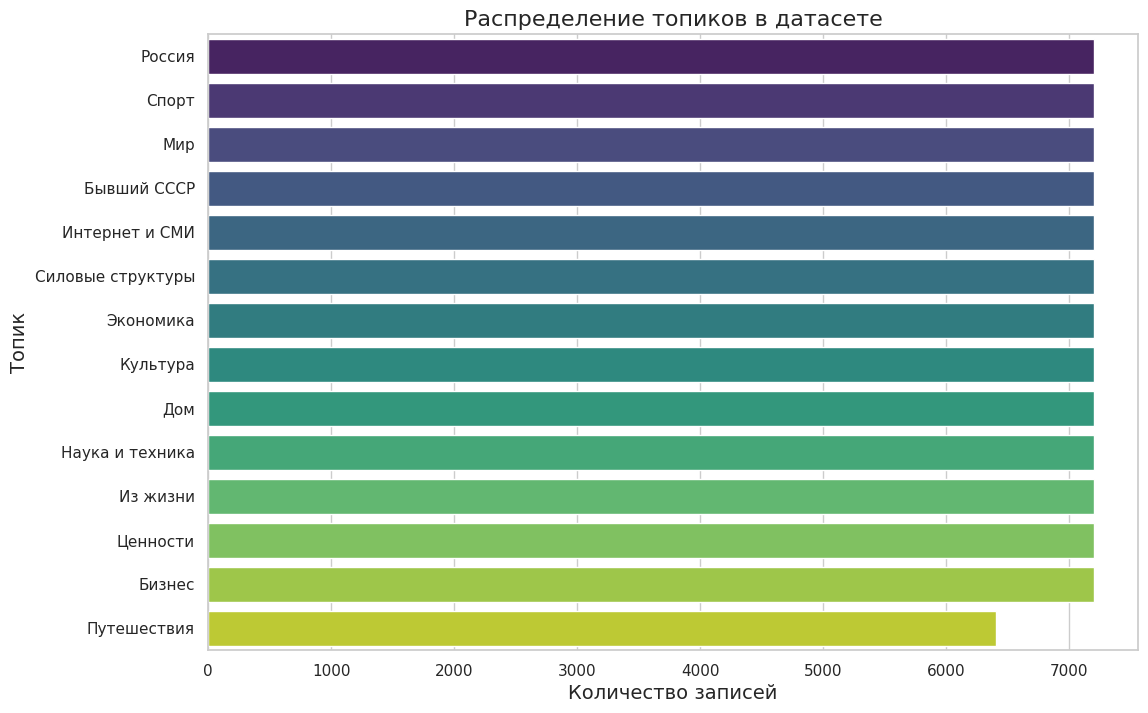

In [ ]:
sns.set(style="whitegrid")
topic_counts = df_final['topic'].value_counts()
plt.figure(figsize=(12, 8))
sns.barplot(x=topic_counts.values, y=topic_counts.index, palette="viridis")
plt.title('Распределение топиков в датасете', fontsize=16)
plt.xlabel('Количество записей', fontsize=14)
plt.ylabel('Топик', fontsize=14)
plt.show()

# Предобработка данных

Заголовок часто содержит ключевые слова темы, поэтому предлагаю объединить заголовки с текстами

In [ ]:
df_final['combined_text'] = df_final['title'] + ' ' + df_final['text']
df_final.head()

,title,text,topic,combined_text
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Названы регионы России с самой высокой смертно...
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Австрия не представила доказательств вины росс...
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Обнаружено самое счастливое место на планете С...
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,В США раскрыли сумму расходов на расследование...
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Хакеры рассказали о планах Великобритании зами...


Для предобработки данных предлагаю реализовать сдедующую нормализацию текста, включающую:

1. Приведение к нижнему регистру для устранения вариативности написания слов;

2. Удаление цифр, специальных символов и знаков пунктуации с помощью регулярных выражений;

3. Лемматизацию с использованием `pymorphy3` (вместо стемминга);
> Лемматизация, в отличие от стемминга, сохраняет семантику и грамматическую корректность, что повышает интерпретируемость признаков.

4. Фильтрацию стоп-слов на основе стандартного списка `nltk` для исключения неинформативных токенов.

In [ ]:
morph = pymorphy3.MorphAnalyzer()
STOP_WORDS = set(stopwords.words('russian'))

In [ ]:
@functools.lru_cache(maxsize=10000)
def get_normal_form(word):
    return morph.parse(word)[0].normal_form

def preprocess(text, debug=False):
    original = text

    lower_text = text.lower()

    cleaned_text = re.sub(r'[^\w\s]|[\d_]', '', lower_text)

    tokens = []
    debug_normalized = []
    for word in cleaned_text.split():
        normalized = get_normal_form(word)
        if normalized and normalized not in STOP_WORDS:
            tokens.append(normalized)
            debug_normalized.append(normalized)

    if debug:
        print(f"Исходный текст:\n{original}\n")
        print(f"Приведение к нижнему регистру:\n{lower_text}\n")
        print(f"Очистка от спецсимволов и цифр:\n{cleaned_text}\n")
        print(f"Нормализация:\n {' '.join(debug_normalized)}")
        print("="*50)

    return ' '.join(tokens)

Обработаем какой-нибудь текст и выведем результат

In [ ]:
preprocess(df_final['combined_text'][3], debug=True)

Исходный текст:
В США раскрыли сумму расходов на расследование «российского дела» С начала расследования российского вмешательства в выборы власти США потратили более 25 миллионов долларов. Об этом сообщает Associated Press со ссылкой на отчет Министерства юстиции США. В документе содержатся данные о расходах на следствие с апреля по сентябрь 2018 года. За эти полгода было потрачено 4,6 миллиона долларов, из которых почти 3 миллиона долларов ушли на зарплату сотрудников, 580 тысяч — на поездки и сопутствующие расходы. Ранее Минюст США уже публиковал отчеты о затратах на дело о российском вмешательстве за предыдущие месяцы. 11 декабря расследование спецпрокурора Робера Мюллера показало, что по меньшей мере 14 человек из окружения президента США Дональда Трампа контактировали с россиянами во время его избирательной кампании и последующего переходного периода перед вступлением в должность главы государства. Мюллер с 2017 года ведет дело о якобы российском вмешательстве в американские выбо

'сша раскрыть сумма расход расследование российский дело начало расследование российский вмешательство выборы власть сша потратить миллион доллар это сообщать associated press ссылка отчёт министерство юстиция сша документ содержаться дать расход следствие апрель сентябрь год полгода потратить миллион доллар который миллион доллар уйти зарплата сотрудник тысяча поездка сопутствовать расход ранее минюст сша публиковать отчёт затрата дело российский вмешательство предыдущий месяц декабрь расследование спецпрокурор робер мюллер показать малый мера человек окружение президент сша дональд трамп контактировать россиянин время избирательный кампания последующий переходный период вступление должность глава государство мюллер год вести дело якобы российский вмешательство американский выборы м поставить задача выяснить сговор штаб трамп россия кремль белый дом отвергать всё обвинение россия неоднократно обвинять вмешательство выборы президент сша помощь хакер июнь спецслужба выдвинуть заочный об

Примененим ко всему датафрейму

In [ ]:
df_final['clean_text'] = df_final['combined_text'].apply(preprocess)
df_final.head()

,title,text,topic,combined_text,clean_text
0,Названы регионы России с самой высокой смертно...,Вице-премьер по социальным вопросам Татьяна Го...,Россия,Названы регионы России с самой высокой смертно...,назвать регион россия высокий смертность рак в...
1,Австрия не представила доказательств вины росс...,Австрийские правоохранительные органы не предс...,Спорт,Австрия не представила доказательств вины росс...,австрия представить доказательство вина россий...
2,Обнаружено самое счастливое место на планете,Сотрудники социальной сети Instagram проанализ...,Путешествия,Обнаружено самое счастливое место на планете С...,обнаружить самый счастливый место планета сотр...
3,В США раскрыли сумму расходов на расследование...,С начала расследования российского вмешательст...,Мир,В США раскрыли сумму расходов на расследование...,сша раскрыть сумма расход расследование россий...
4,Хакеры рассказали о планах Великобритании зами...,Хакерская группировка Anonymous опубликовала н...,Мир,Хакеры рассказали о планах Великобритании зами...,хакер рассказать план великобритания заминиров...


# Разделение датафрейма на train/val/test

Резделим данные на обучающую, валидационную и тестовую выборки (60/20/20)

In [134]:
X_train, X_val_test, y_train, y_val_test = train_test_split(
    df_final['clean_text'], df_final['topic'],
    test_size=0.4, stratify=df_final['topic'], random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5, stratify=y_val_test, random_state=42
)

# **Word2Vec**

## Создание и обучение модели **Word2Vec**

Мы инициализируем модель Word2Vec с следующими гиперпараметрами:

- `vector_size=100`: Размерность эмбеддингов. 100 — это стандартный размер, который хорошо работает для большинства задач.

- `window=5`: Размер окна контекста. Слова, находящиеся в пределах 5 слов от целевого слова, будут учитываться как контекст.

- `min_count=10`: Слова, которые встречаются реже 10 раз, будут игнорироваться. Это помогает избавиться от редких слов, которые могут быть шумом.

- `workers=4`: Количество потоков для параллельной обработки. Увеличивает скорость обучения на многопроцессорных системах.



In [ ]:
tokenized_texts = [text.split() for text in df_final['clean_text']]

In [ ]:
word2vec_model = Word2Vec(
    sentences=tokenized_texts,
    vector_size=100,
    window=5,
    min_count=10,
    workers=4
)

In [ ]:
word2vec_model.save("word2vec.model")

In [ ]:
# word2vec_model = Word2Vec.load("word2vec.model")

## Визуальная оценка качества эмбеддингов

### `doesnt_match`

In [ ]:
test_words = ["россия", "москва", "киев", "яблоко"]
odd_word = word2vec_model.wv.doesnt_match(test_words)
print(f"Слово, которое не подходит: {odd_word}")

Слово, которое не подходит: яблоко


### `most_similar`

In [ ]:
similar_words = word2vec_model.wv.most_similar("россия", topn=5)
print("Слова, близкие к 'россия':")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

Слова, близкие к 'россия':
рф: 0.8006
российский: 0.7911
страна: 0.7146
белоруссия: 0.6510
турция: 0.6295


# Загрузка предобученных эмбеддингов из **NaVec** и **RusVectores**

## Загрузка модели **NaVec**

In [ ]:
!wget https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar

--2025-03-14 12:01:43--  https://storage.yandexcloud.net/natasha-navec/packs/navec_news_v1_1B_250K_300d_100q.tar
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26634240 (25M) [application/x-tar]
Saving to: ‘navec_news_v1_1B_250K_300d_100q.tar’

navec_news_v1_1B_25 100%[===================>]  25.40M  14.6MB/s    in 1.7s    

2025-03-14 12:01:46 (14.6 MB/s) - ‘navec_news_v1_1B_250K_300d_100q.tar’ saved [26634240/26634240]



In [ ]:
path = 'navec_news_v1_1B_250K_300d_100q.tar'
navec = Navec.load(path)

In [ ]:
word = "компьютер"
try:
    vector = navec[word]
    print(f"Вектор для слова '{word}': {vector[:15]}")
except KeyError:
    print(f"Слово '{word}' отсутствует в модели.")

Вектор для слова 'компьютер': [ 0.27130136 -0.23190571 -0.55229765  0.07967507  0.08338855  0.59920526
 -0.00544844 -0.7282295  -0.20194983 -0.17297056  0.36927035  0.5207554
  0.03347137  0.14898756 -0.25637338]


In [ ]:
navec_vectors = KeyedVectors(vector_size=300)

words = list(navec.vocab.word_ids.keys())
vectors = np.array([navec[word] for word in words])

navec_vectors.add_vectors(words, vectors)

In [ ]:
similar_words = navec_vectors.most_similar(word, topn=5)
print(f"Слова, близкие к {word}:")
for word, score in similar_words:
    print(f"{word}: {score:.4f}")

Слова, близкие к компьютер:
ноутбук: 0.6806
планшетный: 0.6744
компьютера: 0.6625
планшет: 0.6209
компьютере: 0.5655


/usr/local/lib/python3.11/dist-packages/gensim/models/keyedvectors.py:849: RuntimeWarning: invalid value encountered in divide
  dists = dot(self.vectors[clip_start:clip_end], mean) / self.norms[clip_start:clip_end]


## Загрузка модели **RusVectores**

In [ ]:
urllib.request.urlretrieve(
    "https://rusvectores.org/static/models/rusvectores4/ruwikiruscorpora/ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz",
    "ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz"
)

('ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz',
 <http.client.HTTPMessage at 0x7f77307d1490>)

In [ ]:
model_path = 'ruwikiruscorpora_upos_skipgram_300_2_2018.vec.gz'
model_ru = gensim.models.KeyedVectors.load_word2vec_format(model_path)

In [ ]:
word = "компьютер"
model_ru.most_similar(positive=[f'{word}_NOUN'], topn=5)

[('pc-совместимый_ADJ', 0.7288894057273865),
 ('ноутбук_NOUN', 0.7180454134941101),
 ('ибм::пк_PROPN', 0.7089871764183044),
 ('микрокомпьютер_NOUN', 0.7030705809593201),
 ('мейнфрейм_NOUN', 0.688766598701477)]

Модель **RusVectores** использует слова в формате `{слово}_{часть_речи}` (например, `кот_NOUN`, `бежать_VERB`), а текст содержит только слова без указания части речи. Это приведет к тому, что большинство слов не находятся в модели, и качество модели упадет.

In [84]:
@lru_cache(maxsize=10000)
def add_pos_to_word(word):
    parsed_word = morph.parse(word)[0]
    pos = parsed_word.tag.POS
    if pos:
        return f"{word}_{pos}"
    else:
        return word

def transform_text_with_pos(text):
    return " ".join([add_pos_to_word(word) for word in text.split()])

In [111]:
X_train_transformed = [transform_text_with_pos(text) for text in X_train]
X_val_transformed = [transform_text_with_pos(text) for text in X_val]
X_test_transformed = [transform_text_with_pos(text) for text in X_test]

# LogisticRegression

## Преобразование текстов в векторы

Для использования моих эмбеддингов **Word2Vec** нужно усреднить векторы слов в каждом тексте

In [127]:
def text_to_vector(text, model):
    vectors = []
    for word in text.split():
        # Получаем вектор слова
        if hasattr(model, 'wv'):  # Для Word2Vec из gensim
            if word in model.wv:
                vectors.append(model.wv[word])
        elif hasattr(model, 'word_ids'):  # Для NaVec
            if word in model:
                vectors.append(model[word])
        else:  # Для KeyedVectors (RusVectores)
            if word in model:
                vectors.append(model[word])

    # Усредняем векторы
    if len(vectors) > 0:
        return np.mean(vectors, axis=0)
    else:
        if hasattr(model, 'vector_size'):
            return np.zeros(model.vector_size)
        elif hasattr(model, 'shape'):
            return np.zeros(model.shape[1])
        else:
            raise ValueError("Не удалось определить размерность векторов модели.")

> `text_to_vector` - это функция для преобразования текста в вектор, усредняя векторы слов

In [ ]:
X_train_w2v = np.array([text_to_vector(text, word2vec_model) for text in X_train])
X_val_w2v = np.array([text_to_vector(text, word2vec_model) for text in X_val])

Аналогично, усредняем векторы слов с использованием модели **NaVec**

In [128]:
X_train_navec = np.array([text_to_vector(text, navec) for text in X_train])
X_val_navec = np.array([text_to_vector(text, navec) for text in X_val])

Усредняем векторы слов с использованием модели **RusVectores**

In [87]:
X_train_rusvectores = np.array([text_to_vector(text, model_ru) for text in X_train_transformed])
X_val_rusvectores = np.array([text_to_vector(text, model_ru) for text in X_val_transformed])

## Обучение моделей

In [ ]:
model_w2v = LogisticRegression(solver='saga', tol=1e-3, max_iter=100, class_weight='balanced', random_state=42)
model_w2v.fit(X_train_w2v, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='saga',
                   tol=0.001)

In [129]:
model_navec = LogisticRegression(solver='saga', tol=1e-3, max_iter=100, class_weight='balanced', random_state=42)
model_navec.fit(X_train_navec, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='saga',
                   tol=0.001)

In [88]:
model_rusvectores = LogisticRegression(solver='saga', tol=1e-3, max_iter=100, class_weight='balanced', random_state=42)
model_rusvectores.fit(X_train_rusvectores, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='saga',
                   tol=0.001)

## Оценка на валидационной выборке

In [ ]:
y_val_pred_w2v = model_w2v.predict(X_val_w2v)
report_w2v = classification_report(y_val, y_val_pred_w2v, digits=4)
print(f"Classification Report (Word2Vec):\n {report_w2v}")

Classification Report (Word2Vec):
                    precision    recall  f1-score   support

           Бизнес     0.6702    0.7125    0.6907      1440
      Бывший СССР     0.8608    0.8458    0.8532      1440
              Дом     0.8401    0.8208    0.8303      1440
         Из жизни     0.7285    0.7417    0.7350      1440
   Интернет и СМИ     0.7500    0.7604    0.7552      1440
         Культура     0.8555    0.8431    0.8492      1440
              Мир     0.7321    0.7667    0.7490      1440
  Наука и техника     0.8419    0.8653    0.8534      1440
      Путешествия     0.8268    0.8462    0.8364      1281
           Россия     0.6364    0.5882    0.6113      1440
Силовые структуры     0.7304    0.7491    0.7396      1439
            Спорт     0.9538    0.9597    0.9567      1440
         Ценности     0.8922    0.8965    0.8944      1440
        Экономика     0.7054    0.6368    0.6693      1440

         accuracy                         0.7876     20000
        macro avg  

In [130]:
y_val_pred_navec = model_navec.predict(X_val_navec)
report_navec = classification_report(y_val, y_val_pred_navec, digits=4)
print(f"Classification Report (NaVec):\n {report_navec}")

Classification Report (NaVec):
                    precision    recall  f1-score   support

           Бизнес     0.6920    0.7146    0.7031      1440
      Бывший СССР     0.8767    0.8688    0.8727      1440
              Дом     0.8457    0.8222    0.8338      1440
         Из жизни     0.7400    0.7472    0.7436      1440
   Интернет и СМИ     0.7718    0.7632    0.7675      1440
         Культура     0.8652    0.8556    0.8603      1440
              Мир     0.7417    0.7937    0.7669      1440
  Наука и техника     0.8444    0.8667    0.8554      1440
      Путешествия     0.8286    0.8603    0.8441      1281
           Россия     0.6720    0.6444    0.6579      1440
Силовые структуры     0.7379    0.7436    0.7407      1439
            Спорт     0.9466    0.9611    0.9538      1440
         Ценности     0.9017    0.8917    0.8966      1440
        Экономика     0.7056    0.6458    0.6744      1440

         accuracy                         0.7980     20000
        macro avg     

In [89]:
y_val_pred_rusvectores = model_rusvectores.predict(X_val_rusvectores)
report_rusvectores = classification_report(y_val, y_val_pred_rusvectores, digits=4)
print(f"Classification Report (RusVectores):\n {report_rusvectores}")

Classification Report (RusVectores):
                    precision    recall  f1-score   support

           Бизнес     0.6188    0.6729    0.6447      1440
      Бывший СССР     0.8189    0.7819    0.8000      1440
              Дом     0.8108    0.7646    0.7870      1440
         Из жизни     0.6555    0.6792    0.6671      1440
   Интернет и СМИ     0.7107    0.6910    0.7007      1440
         Культура     0.8088    0.8076    0.8082      1440
              Мир     0.6588    0.7000    0.6788      1440
  Наука и техника     0.8041    0.8153    0.8097      1440
      Путешествия     0.7808    0.8259    0.8027      1281
           Россия     0.5968    0.5458    0.5702      1440
Силовые структуры     0.6458    0.6803    0.6626      1439
            Спорт     0.9331    0.9396    0.9363      1440
         Ценности     0.8712    0.8458    0.8584      1440
        Экономика     0.6379    0.5958    0.6162      1440

         accuracy                         0.7383     20000
        macro av

## Вывод

Лучший результат у **NaVec** (accuracy: 0.7980)

# LogisticRegression (взвешенные эмбеддинги + TF-IDF)

## Вычисление TF-IDF

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

Преобразуем разреженную матрицу TF-IDF в формат CSR для эффективного доступа

In [ ]:
X_train_tfidf_csr = csr_matrix(X_train_tfidf)
X_val_tfidf_csr = csr_matrix(X_val_tfidf)

## Взвешенное усреднение эмбеддингов

In [91]:
def text_to_vector_tfidf(text, model, tfidf_vectorizer, X_train_tfidf_csr, index):
    vectors = []
    weights = []

    # Получаем TF-IDF веса для текста
    tfidf_weights = X_train_tfidf_csr[index]

    for word in text.split():
        # Получаем индекс слова в словаре TF-IDF
        word_idx = tfidf_vectorizer.vocabulary_.get(word)
        if word_idx is not None:
            # Получаем вектор слова
            if hasattr(model, 'wv'):  # Для Word2Vec из gensim
                if word in model.wv:
                    vectors.append(model.wv[word])
                    weights.append(tfidf_weights[0, word_idx])
            elif hasattr(model, 'word_ids'):  # Для NaVec
                if word in model:
                    vectors.append(model[word])
                    weights.append(tfidf_weights[0, word_idx])
            else:  # Для KeyedVectors (RusVectores)
                if word in model:
                    vectors.append(model[word])
                    weights.append(tfidf_weights[0, word_idx])

    # Взвешенное усреднение векторов
    if len(vectors) > 0:
        weights = np.array(weights)
        weights = weights / weights.sum()
        return np.average(vectors, axis=0, weights=weights)
    else:
        if hasattr(model, 'vector_size'):
            return np.zeros(model.vector_size)
        elif hasattr(model, 'shape'):
            return np.zeros(model.shape[1])
        else:
            raise ValueError("Не удалось определить размерность векторов модели.")

## Применение взвешенного усреднения

In [ ]:
X_train_weighted_navec = np.array([text_to_vector_tfidf(text, navec, tfidf_vectorizer, X_train_tfidf_csr, i) for i, text in enumerate(X_train)])
X_val_weighted_navec = np.array([text_to_vector_tfidf(text, navec, tfidf_vectorizer, X_val_tfidf_csr, i) for i, text in enumerate(X_val)])

## Обучение моделей

In [ ]:
model_weighted_navec = LogisticRegression(solver='saga', tol=1e-3, max_iter=100, class_weight='balanced', random_state=42)
model_weighted_navec.fit(X_train_weighted_navec, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='saga',
                   tol=0.001)

## Оценка на валидационной выборке

In [ ]:
y_val_pred_weighted_navec = model_weighted_navec.predict(X_val_weighted_navec)
report_weighted_navec = classification_report(y_val, y_val_pred_weighted_navec, digits=4)
print(f"Classification Report (NaVec):\n {report_weighted_navec}")

Classification Report (NaVec):
                    precision    recall  f1-score   support

           Бизнес     0.6776    0.6875    0.6825      1440
      Бывший СССР     0.8464    0.8340    0.8402      1440
              Дом     0.8251    0.7764    0.8000      1440
         Из жизни     0.6569    0.6847    0.6705      1440
   Интернет и СМИ     0.7251    0.7069    0.7159      1440
         Культура     0.8204    0.8278    0.8241      1440
              Мир     0.7114    0.7514    0.7308      1440
  Наука и техника     0.8107    0.8444    0.8272      1440
      Путешествия     0.7944    0.8236    0.8087      1281
           Россия     0.6057    0.5910    0.5982      1440
Силовые структуры     0.7001    0.6928    0.6965      1439
            Спорт     0.9436    0.9417    0.9426      1440
         Ценности     0.8723    0.8681    0.8702      1440
        Экономика     0.6784    0.6403    0.6588      1440

         accuracy                         0.7617     20000
        macro avg     

# Сравнение качества всех моделей на тестовой выборке

In [104]:
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_test_tfidf_csr = csr_matrix(X_test_tfidf)

In [135]:
X_test_w2v = np.array([text_to_vector(text, word2vec_model) for text in X_test])
X_test_navec = np.array([text_to_vector(text, navec) for text in X_test])
X_test_navec_weighted = np.array([text_to_vector_tfidf(text, navec, tfidf_vectorizer, X_test_tfidf_csr, i) for i, text in enumerate(X_test)])
X_test_rusvectores = np.array([text_to_vector(text, model_ru) for text in X_test_transformed])

In [136]:
y_test_pred_w2v = model_w2v.predict(X_test_w2v)
y_test_pred_navec = model_navec.predict(X_test_navec)
y_test_pred_navec_weighted = model_weighted_navec.predict(X_test_navec_weighted)
y_test_pred_rusvectores = model_rusvectores.predict(X_test_rusvectores)

In [137]:
results = [
    (y_test_pred_w2v, "Word2Vec (обычное усреднение)"),
    (y_test_pred_navec, "NaVec (обычное усреднение)"),
    (y_test_pred_navec_weighted, "NaVec (взвешенное усреднение + TF-IDF)"),
    (y_test_pred_rusvectores, "RusVectores (обычное усреднение)")
]

for y_test_pred, model_name in results:
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Accuracy ({model_name}): {accuracy:.4f}")

Accuracy (Word2Vec (обычное усреднение)): 0.7903
Accuracy (NaVec (обычное усреднение)): 0.7990
Accuracy (NaVec (взвешенное усреднение + TF-IDF)): 0.7618
Accuracy (RusVectores (обычное усреднение)): 0.7439


# Вывод

**Word2Vec (обычное усреднение)** показал хорошее качество с точностью **0.7903**. Это подтверждает, что усреднение векторов Word2Vec является эффективным подходом для классификации текстов, даже без использования дополнительных методов, таких как TF-IDF.

**NaVec (обычное усреднение)** продемонстрировал наилучший результат с точностью **0.7990**. Это говорит о том, что предобученные эмбеддинги NaVec хорошо подходят для задач классификации текстов на русском языке, превосходя Word2Vec по точности.

**NaVec (взвешенное усреднение + TF-IDF)** показал результат **0.7618**, что хуже, чем обычное усреднение. Это может быть связано с тем, что TF-IDF веса не всегда улучшают качество, особенно если тексты содержат много уникальных слов или шума.

**RusVectores (обычное усреднение)** показал самый низкий результат — **0.7383**. Это может быть связано с необходимостью преобразования слов в формат `{слово}_{часть_речи}` и недостаточным покрытием слов в модели. Возможно, RusVectores требует более тщательной предобработки текстов или использования других методов для повышения качества.

В целом, наилучшие результаты показали модели NaVec и Word2Vec, что делает их предпочтительными для задач классификации текстов на русском языке. RusVectores, несмотря на низкий результат, может быть улучшен за счет более точного преобразования текстов и увеличения покрытия слов.